# Canal de Keltner para previsão do dólar

Desenvolvido por Chester Keltner nos anos 60 e melhorado por Linda Raschke nos anos 80. É um indicador que usa ATR (Average True Range) e é majoritariamente usado para definir tendencias e volatidades do mercado. Pode ser usado para prever dólar mas geralmente é usado para encontrar pontos de entrada em trading.

### Dependencias

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

### Arquivos do dólar

In [22]:
df = pd.read_csv('Dolar.csv', sep=';', decimal=',', encoding='utf-8')
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
df = df.sort_values('Data').reset_index(drop=True)

### Average True Range (ATR)
O ATR é a média de amplitude de variação. Um indicador projetado com o intuito de mensurar volatidade.
Ele é o maior valor em meio a três intervalos:
- máxima menos a mínima do período
- a máxima do período menos o fechamento do período anterior
- o fechamento do período anterior menos a mínima atual

Dado pela formula:

O *Average True Range* (ATR) é definido como:

$$
ATR = MME(TR)
$$

onde o *True Range* (TR) é:

$$
TR = \max(H - L,\; H - C_{p},\; C_{p} - L)
$$


In [23]:
def getATR(data, period=14):
    high_low = data['Valor'].diff().abs()
    high_close = (data['Valor'] - data['Valor'].shift(1)).abs()
    low_close = (data['Valor'] - data['Valor'].shift(1)).abs()
    
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=period).mean()
    return atr

### Canal de Keltner



In [24]:
def getKeltnerChannel(data, ema_period=20, atr_period=14, multiplier=2):
    data['EMA'] = data['Valor'].ewm(span=ema_period).mean()
    atr = getATR(data, atr_period)
    data['KC_Upper'] = data['EMA'] + (atr * multiplier)
    data['KC_Lower'] = data['EMA'] - (atr * multiplier)
    return data



In [25]:
df = getKeltnerChannel(df)

df['Previsao'] = np.where(
    df['Valor'] > df['KC_Upper'],
    df['EMA'] - (df['Valor'] - df['KC_Upper']),
    np.where(
        df['Valor'] < df['KC_Lower'],
        df['EMA'] + (df['KC_Lower'] - df['Valor']),
        df['Valor']
    )
)

split_date = df['Data'].max() - timedelta(days=30)
train_data = df[df['Data'] <= split_date]
test_data = df[df['Data'] > split_date]

### Conclusão

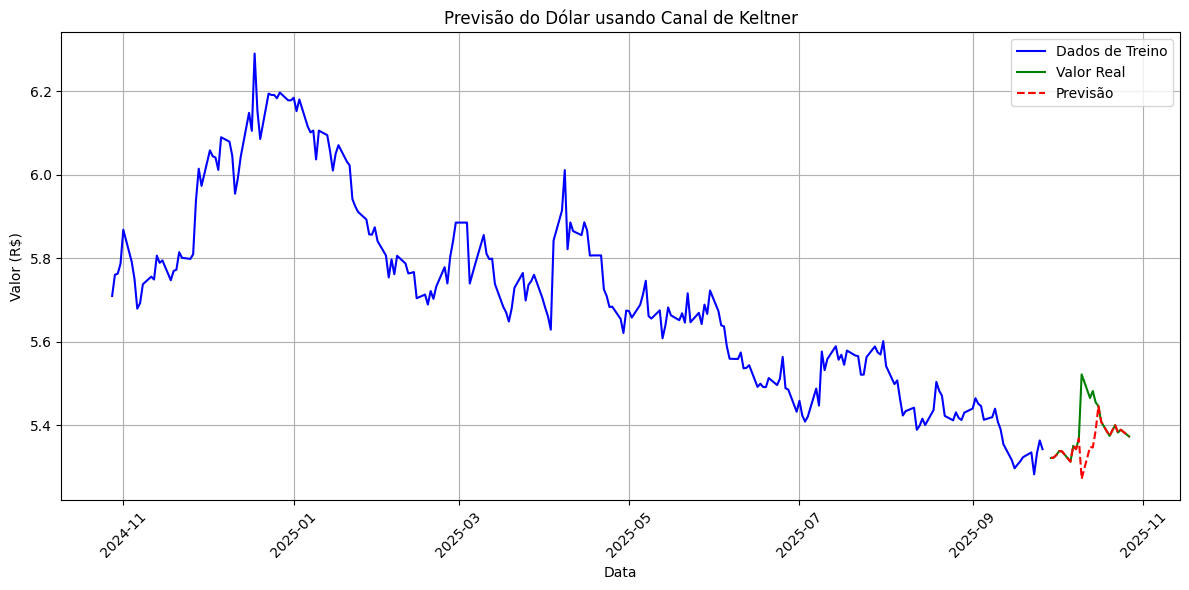

Erros na previsão:
MSE: 0.004718
RMSE: 0.068687
MAE: 0.027161


In [26]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Data'], train_data['Valor'], label='Dados de Treino', color='blue')
plt.plot(test_data['Data'], test_data['Valor'], label='Valor Real', color='green')
plt.plot(test_data['Data'], test_data['Previsao'], label='Previsão', color='red', linestyle='--')
plt.title('Previsão do Dólar usando Canal de Keltner')
plt.xlabel('Data')
plt.ylabel('Valor (R$)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

mse = np.mean((test_data['Valor'] - test_data['Previsao']) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(test_data['Valor'] - test_data['Previsao']))

print(f"Erros na previsão:")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")


O Canal de Keltner não preve com eficacia o dólar pela quantidade de variaveis que ele depende, ele é um indicador usado em trading pois a volatidade tem menos influencias.

### Refêrencias

- https://chartschool-stockcharts-com.translate.goog/table-of-contents/technical-indicators-and-overlays/technical-overlays/keltner-channels?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=tc&_x_tr_hist=true

- https://www.modalmais.com.br/blog/indicador-atr/